<a href="https://colab.research.google.com/github/ronsegev98/MusicGenreClassification/blob/main/MusicGenreClassification_DorRon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classification

## By Dor Avrahami and Ron Segev

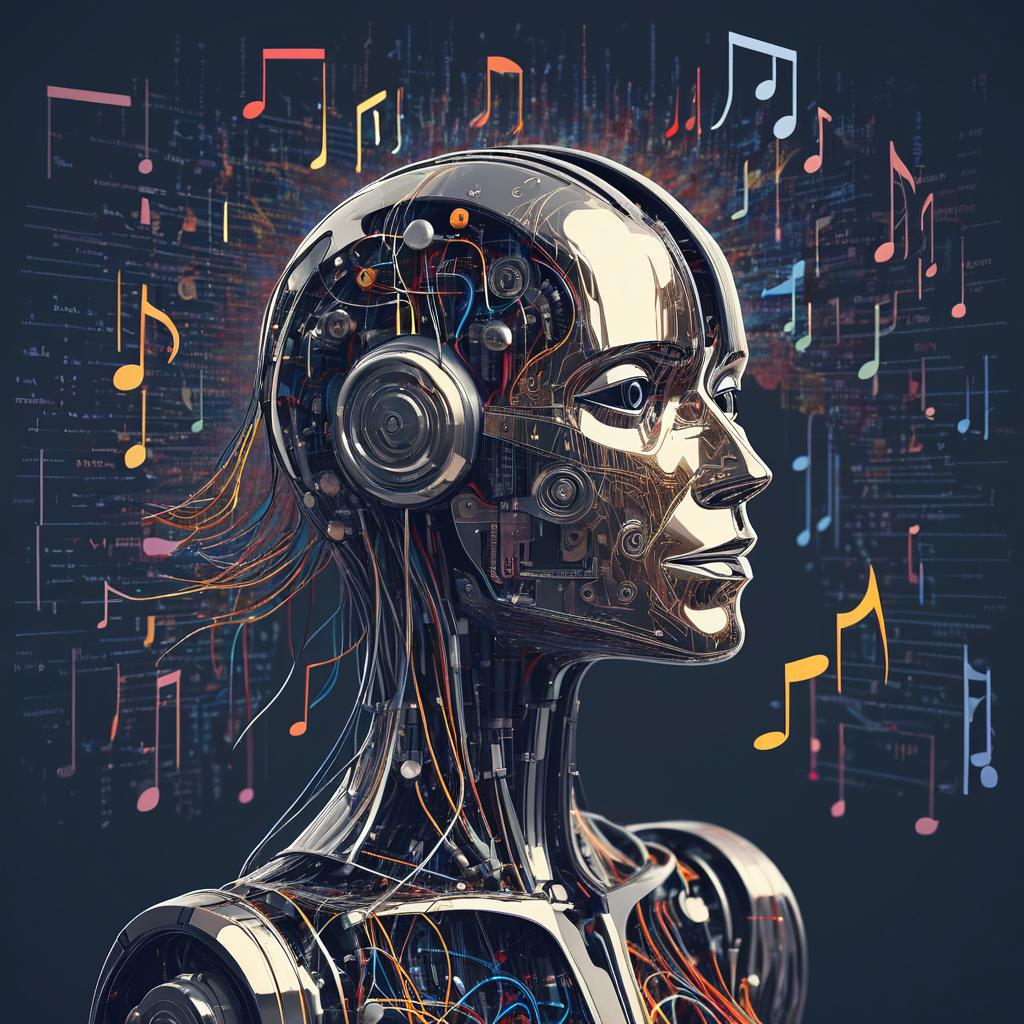

# Loading the data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D,MaxPooling1D,MaxPooling2D ,Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import json
import random
import librosa.display
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')




# Train/Test/Val split

We split our dataset into 80% Train, 10% Test, and 10% Validation

In [ ]:
def load_data(base_dir, max_files_per_genre=99):
    data = []
    for genre in os.listdir(base_dir):
        genre_dir = os.path.join(base_dir, genre)
        file_count = 0
        for file_name in os.listdir(genre_dir):
            if file_count >= max_files_per_genre:
                break
            file_path = os.path.join(genre_dir, file_name)
            data.append((file_path, genre))
            file_count += 1
    return data



def split_data(data, test_size=0.1, val_size=0.1):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size / (1 - test_size), random_state=42)
    return train_data, val_data, test_data



# Preprocessing

### Segmenting audio




We explore two approaches to segment audio data: continuous and split. The continuous segmentation approach, implemented in the segment_audio function, divides the audio into equal-length segments based on a specified segment length (In our case we will use 1,3 & 10 seconds). This approach allows us to analyze the audio in fixed-length continuous segments.

On the other hand, the split segmentation approach, implemented in the segment_audio_split function, randomly selects 25 sub-segments of specified lengths from the audio and concatenates them to form a single segment. The function returns a list of tuples, where each tuple contains the concatenated audio segment and a list of start and end times for each sub-segment. This approach enables us to analyze the audio using a combination of non-continuous sub-segments of varying lengths.

The purpose of these segmentation techniques is to prepare the audio data for further analysis and feature extraction. By dividing the audio into smaller segments, we reduce computational time and cost. These techniques provide flexibility in analyzing audio data by considering both continuous and split segments, allowing for a comprehensive exploration of the audio features and their impact on genre classification.



In [ ]:
segment_times = {}  #dictionary to store the start and end times of the best segments


In [ ]:
def segment_audio(audio, sr, segment_length):
    samples_per_segment = int(sr * segment_length)
    total_segments = int(np.floor(len(audio) / samples_per_segment))

    segments_info = []
    for i in range(0, total_segments * samples_per_segment, samples_per_segment):
        segment = audio[i:i + samples_per_segment]
        start_time = i / sr
        end_time = (i + samples_per_segment) / sr
        segments_info.append((segment, start_time, end_time))

    return segments_info


def segment_audio_split(audio, sr, segment_lengths, num_examples=25):
    total_length = len(audio) // sr

    segments_info = []
    for _ in range(num_examples):
        segment = np.array([])
        times = []  # store start and end times for each sub-segment

        for sub_segment_length in segment_lengths:
            sub_start_time = round(random.uniform(0, total_length - sub_segment_length), 1)
            sub_end_time = sub_start_time + sub_segment_length

            start = int(sub_start_time * sr)
            end = int(sub_end_time * sr)
            segment = np.concatenate((segment, audio[start:end]))

            times.append((sub_start_time, sub_end_time))  # Store each sub-segment's start and end times

        segments_info.append((segment, times))  # Store the combined segment and all sub-segment times

    return segments_info

### Extracting features using MFCC

Visualizing MFCC

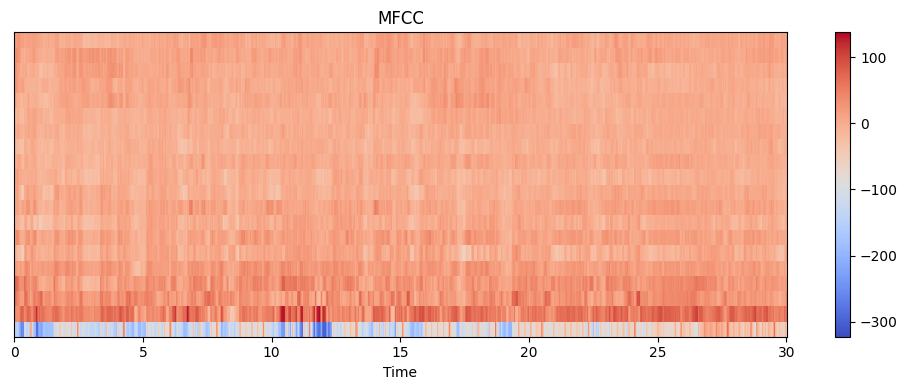

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/final_project/genres_new/pop/pop.00000.wav')

mfccs = librosa.feature.mfcc(y=y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

MFCC (Mel-Frequency Cepstral Coefficients) captures the important characteristics of the audio signal by converting it into a compact representation that emphasizes the perceptually significant aspects of human hearing. MFCC is derived from the mel-frequency cepstrum. In addition to extracting the MFCC features, we will extract the mean and standard deviation of the MFCC coefficients. These measures provide a summary of the distribution of the MFCC values across the audio signal. The mean MFCC values capture the average spectral characteristics, while the standard deviation represents the variability or spread of the MFCC values.

The n_mfcc parameter determines the number of MFCCs to compute for each audio frame. In this case, n_mfcc=13 means that we are extracting 13 MFCC features for each frame of the audio signal. The choice of 13 coefficients is based on empirical studies and has been found to provide a good balance between capturing important audio characteristics and computational efficiency.

In [ ]:
def extract_features(audio_segment, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=n_mfcc)
    mean_mfccs = np.mean(mfccs, axis=1)
    var_mfccs = np.var(mfccs, axis=1)
    return mean_mfccs, var_mfccs

### Finding best MFCC using mean

As a baseline, we begin by using the MFCC max mean

 The function selects the segment with the highest mean MFCC value as the best segment for each length or split segment length.
  
  MFCC features capture important spectral information about the audio signal. Higher mean MFCC values typically indicate segments with more prominent or distinctive spectral characteristics. By selecting the segments with the highest mean MFCC, we aim to identify the most representative or informative parts of the audio signal.

In [ ]:
def find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments=False):
    best_segments = {}
    segment_times = {}

    if not use_split_segments:
        for segment_length in segment_lengths:
            segments_info = segment_audio(audio, sr, segment_length)
            best_mean = float('-inf')
            best_segment = None
            best_time = None

            for segment, start_time, end_time in segments_info:
                features = extract_features(segment, sr)
                mean_mfccs = np.mean(features[0])
                if mean_mfccs > best_mean:
                    best_mean = mean_mfccs
                    best_segment = (segment, features)
                    best_time = (start_time, end_time)

            best_segments[segment_length] = best_segment
            segment_times[segment_length] = best_time
    else:
        for split_segment in split_segment_lengths:
            segments_info = segment_audio_split(audio, sr, split_segment, 10)
            best_mean = float('-inf')
            best_segment_info = None

            for segment, times in segments_info:
                features = extract_features(segment, sr)
                mean_mfccs = np.mean(features[0])

                if mean_mfccs > best_mean:
                    best_mean = mean_mfccs
                    best_segment_info = (segment, features, times)

            if best_segment_info:
                best_segments[tuple(split_segment)] = best_segment_info[:2]  # segment and features
                segment_times[tuple(split_segment)] = best_segment_info[2]  # times

    return best_segments, segment_times



### Prepare data for models

Our goal in the `process_data` function is to prepare the audio data for genre classification by extracting the best segments and their corresponding features. We load each audio file, find the best segments using the `find_best_segments` function, and store the segment features and their genre labels in dictionaries and lists.

In the `prepare_data` function, our objective is to preprocess the extracted features and encode the genre labels. We encode the labels using a label encoder and scale the features using either a MinMaxScaler or a StandardScaler, depending on the specified scaler type.

We treat KNN differently because it is a distance-based algorithm that relies on the distances between data points for making predictions. To ensure fair distance calculations and prevent bias, we want to normalize or scale the features to a consistent range. If the scaler type is 'minmax', we use a MinMaxScaler to scale the features to [0, 1]. Otherwise, we use a StandardScaler to standardize the features by removing the mean and scaling to unit variance.

In [ ]:
def process_data(data, segment_lengths, split_segment_lengths, use_split_segments=False):
    global segment_times  # Declare segment_times as global to access the same dictionary

    X = {length: [] for length in (segment_lengths if not use_split_segments else [tuple(split) for split in split_segment_lengths])}
    y = []

    for file_path, genre in data:
        audio, sr = librosa.load(file_path)
        best_segments, times = find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments)
        segment_times.update(times)  # Update the global segment_times dictionary with the new times

        for segment_key, (segment, features) in best_segments.items():
            X[segment_key].append(np.concatenate(features))
        y.append(genre)

    return X, y


#added min/max scaler for normalization KNN
def prepare_data(X, y, scaler_type='standard'):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    X_scaled = {}
    for segment_key, features in X.items():
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()
        X_scaled[segment_key] = scaler.fit_transform(features)
    return X_scaled, y_encoded






# Models

We employed three different models - CNN, XGBoost, and KNN - to provide a comprehensive approach to music genre classification. Each model brings its unique strengths and perspectives to solving the problem.

We utilized CNN (Convolutional Neural Networks) for their ability to capture local patterns and spatial features in the spectral information. CNNs excel at learning meaningful features from the spectral representations of audio, making them particularly suitable for audio classification tasks.

XGBoost, a powerful Gradient Boosting algorithm, was employed since it is particularly effective in handling non-linear relationships and complex feature interactions in the data, making it a strong candidate for tasks like this where the relationship between features and the target variable is intricate and not easily modeled by linear methods.

We also employed KNN (K-Nearest Neighbors), a simple and intuitive algorithm that performs classification based on the similarity between samples. It considers the nearest neighbors in the feature space to determine the classification. KNN captures local relationships and similarities between audio samples, providing a different perspective on the classification problem.

By combining these three models, we leveraged the unique strengths of each one. We can compare their performances, analyze the differences in their predictions, and gain deeper insights into the problem. Using multiple models allows us to obtain a more comprehensive picture and increases our confidence in the classification results.

### CNN

We chose to use a 1D CNN model, as it can be specifically designed for processing sequential data, such as audio signals.

1D Convolutional Layers: These layers are adept at extracting features from sequence data, making them ideal for audio where patterns unfold over time. The model uses two convolutional layers with increasing numbers of filters (64 and 128), allowing it to learn increasingly complex and abstract representations of the input data.

MaxPooling Layers: After each convolutional layer, max pooling is used to shrink the data size, which lowers the computation needed and helps identify the most important features that stay consistent even when their position changes slightly.

ReLU Activation: Employed within the convolutional layers, the ReLU activation function introduces non-linearity, enabling the model to learn more complex patterns in the data.

Flatten and Dense Layers: After convolutional and pooling layers, the model flattens the output and uses dense layers to combine the features into higher-level representations, which are then used for classification.

Dropout: To mitigate overfitting, a dropout layer is included.

Output Layer with Softmax Activation: The final layer is a softmax activation function that outputs a probability distribution over the classes, making the model suitable for multi-class classification.



In [ ]:
#For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_cnn(X_train, y_train, X_val, y_val, segment_key, num_classes):
    input_shape = (X_train[segment_key].shape[1], 1)
    model = create_cnn_model(input_shape, num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train[segment_key].reshape(-1, input_shape[0], 1),
                        y_train,
                        validation_data=(X_val[segment_key].reshape(-1, input_shape[0], 1), y_val),
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=0)
    return model, history

### XGboost

max_depth=5: A depth of 5 is a balanced choice that allows the trees to capture complex patterns in the data without becoming too specific (which can lead to overfitting). It defines how deep each tree can grow during any boosting round.

reg_alpha=0.01 (L1 regularization): A small value like 0.01 helps prevent overfitting by penalizing large weights.

reg_lambda=1.0 (L2 regularization): L2 regularization helps to avoid overfitting by smoothing the weights of the features. A value of 1.0 provides a moderate level of regularization, balancing the model's complexity and its ability to generalize.

n_estimators=100: A hundred trees are enough to capture the patterns in the data without requiring excessive computation time. It's a compromise between model complexity and training efficiency.

early_stopping_rounds=10: This parameter is used to prevent overfitting. It stops the training process if the model's performance on the validation set does not improve for 10 consecutive rounds. Early stopping helps in finding the optimal number of boosting rounds and can reduce the training time.

In [ ]:
def train_xgboost(X_train, y_train, X_val, y_val, segment_key):
    model = XGBClassifier(
        random_state=42,
        max_depth=5,
        reg_alpha=0.01,       # L1 regularization
        reg_lambda=1.0,       # L2 regularization
        n_estimators=100      # Number of gradient boosted trees
    )
    eval_set = [(X_val[segment_key], y_val)]
    model.fit(
        X_train[segment_key],
        y_train,
        eval_set=eval_set,
        early_stopping_rounds=10,
        verbose=False
    )
    return model

###KNN

Using n_neighbors=5 as a baseline for KNN was our choice because it provides a good balance between underfitting and overfitting.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn(X_train, y_train, X_val, y_val, n_neighbors=5):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

# Evaluation Pipeline

We created functions to easily test our feature extraction methods.

In [ ]:
def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test, segment_keys):

    results = {}
    for segment_key in segment_keys:
        cnn_model, cnn_history = models[segment_key]['cnn']
        xgboost_model = models[segment_key]['xgboost']
        knn_model = models[segment_key]['knn']

        cnn_train_acc = cnn_history.history['accuracy'][-1]
        cnn_val_acc = cnn_history.history['val_accuracy'][-1]
        cnn_test_acc = cnn_model.evaluate(X_test[segment_key].reshape(-1, X_test[segment_key].shape[1], 1), y_test, verbose=0)[1]

        xgboost_train_acc = accuracy_score(y_train, xgboost_model.predict(X_train[segment_key]))
        xgboost_val_acc = accuracy_score(y_val, xgboost_model.predict(X_val[segment_key]))
        xgboost_test_acc = accuracy_score(y_test, xgboost_model.predict(X_test[segment_key]))

        knn_train_acc = accuracy_score(y_train, knn_model.predict(X_train[segment_key]))
        knn_val_acc = accuracy_score(y_val, knn_model.predict(X_val[segment_key]))
        knn_test_acc = accuracy_score(y_test, knn_model.predict(X_test[segment_key]))

        results[segment_key] = {
            'cnn': {
                'train_accuracy': cnn_train_acc,
                'val_accuracy': cnn_val_acc,
                'test_accuracy': cnn_test_acc
            },
            'xgboost': {
                'train_accuracy': xgboost_train_acc,
                'val_accuracy': xgboost_val_acc,
                'test_accuracy': xgboost_test_acc
            },
            'knn': {
                'train_accuracy': knn_train_acc,
                'val_accuracy': knn_val_acc,
                'test_accuracy': knn_test_acc
            }
        }
    return results


Creating a pipeline for evaluation

In [ ]:
def music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre):
    segment_lengths = [1, 3, 10]
    split_segment_lengths = [(0.5, 0.5), (1, 2), (1.5, 1.5), (5, 5), (3, 3, 4)]


    data = load_data(base_dir, max_files_per_genre=max_files_per_genre)
    train_data, val_data, test_data = split_data(data)

    X_train, y_train = process_data(train_data, segment_lengths, split_segment_lengths, use_split_segments)
    X_val, y_val = process_data(val_data, segment_lengths, split_segment_lengths, use_split_segments)
    X_test, y_test = process_data(test_data, segment_lengths, split_segment_lengths, use_split_segments)

    X_train_scaled_cnn, y_train_encoded = prepare_data(X_train, y_train)
    X_val_scaled_cnn, y_val_encoded = prepare_data(X_val, y_val)
    X_test_scaled_cnn, y_test_encoded = prepare_data(X_test, y_test)

    X_train_scaled_knn, _ = prepare_data(X_train, y_train, scaler_type='minmax')
    X_val_scaled_knn, _ = prepare_data(X_val, y_val, scaler_type='minmax')
    X_test_scaled_knn, _ = prepare_data(X_test, y_test, scaler_type='minmax')

    num_classes = len(set(y_train))
    segment_keys = list(X_train_scaled_cnn.keys())

    models = {}
    for segment_key in segment_keys:
        cnn_model, cnn_history = train_cnn(X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, segment_key, num_classes)
        xgboost_model = train_xgboost(X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, segment_key)
        knn_model = train_knn(X_train_scaled_knn[segment_key], y_train_encoded, X_val_scaled_knn[segment_key], y_val_encoded)

        models[segment_key] = {
            'cnn': (cnn_model, cnn_history),
            'xgboost': xgboost_model,
            'knn': knn_model
        }

    results = evaluate_models(models, X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, X_test_scaled_cnn, y_test_encoded, segment_keys)

    print(f"Using {'split segments' if use_split_segments else 'continuous segments'}")

    for segment_key, result in results.items():
        print(f"\nSegment Key: {segment_key}")
        print("CNN Results:")
        print(f"  Train Accuracy: {result['cnn']['train_accuracy']:.4f}")
        print(f"  Validation Accuracy: {result['cnn']['val_accuracy']:.4f}")
        print(f"  Test Accuracy: {result['cnn']['test_accuracy']:.4f}")
        print("XGBoost Results:")
        print(f"  Train Accuracy: {result['xgboost']['train_accuracy']:.4f}")
        print(f"  Validation Accuracy: {result['xgboost']['val_accuracy']:.4f}")
        print(f"  Test Accuracy: {result['xgboost']['test_accuracy']:.4f}")
        print("KNN Results:")
        print(f"  Train Accuracy: {result['knn']['train_accuracy']:.4f}")
        print(f"  Validation Accuracy: {result['knn']['val_accuracy']:.4f}")
        print(f"  Test Accuracy: {result['knn']['test_accuracy']:.4f}")

        # Find the best model for the current segment
        best_model = max(result, key=lambda x: result[x]['test_accuracy'])
        print(f"Best Model for Segment Key {segment_key}: {best_model}")



    return results

### Continuous Segments on MFCC Max Mean

In [ ]:

base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'


use_split_segments = False
max_files_per_genre = 99

results_continuous_mean = music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre)

Using continuous segments

Segment Key: 1
CNN Results:
  Train Accuracy: 0.7588
  Validation Accuracy: 0.5657
  Test Accuracy: 0.5556
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.4747
  Test Accuracy: 0.5354
KNN Results:
  Train Accuracy: 0.4280
  Validation Accuracy: 0.3434
  Test Accuracy: 0.3434
Best Model for Segment Key 1: cnn

Segment Key: 3
CNN Results:
  Train Accuracy: 0.7298
  Validation Accuracy: 0.5253
  Test Accuracy: 0.5354
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5051
  Test Accuracy: 0.5758
KNN Results:
  Train Accuracy: 0.4583
  Validation Accuracy: 0.3333
  Test Accuracy: 0.3535
Best Model for Segment Key 3: xgboost

Segment Key: 10
CNN Results:
  Train Accuracy: 0.7841
  Validation Accuracy: 0.5758
  Test Accuracy: 0.5758
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.6364
  Test Accuracy: 0.6162
KNN Results:
  Train Accuracy: 0.4394
  Validation Accuracy: 0.3737
  Test Accuracy: 0.3939
Best Model fo

### Continuous Segments on MFCC Max Var

In [ ]:
def find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments=False):
    global segment_times

    best_segments = {}
    if not use_split_segments:
        for segment_length in segment_lengths:
            segments_info = segment_audio(audio, sr, segment_length)
            best_variance = float('-inf')
            best_segment = None
            best_time = None

            for segment, start_time, end_time in segments_info:
                features = extract_features(segment, sr)
                variance_mfccs = np.var(features[0])
                if variance_mfccs > best_variance:
                    best_variance = variance_mfccs
                    best_segment = (segment, features)
                    best_time = (start_time, end_time)

            best_segments[segment_length] = best_segment
            segment_times[segment_length] = best_time
    else:
        for split_segment in split_segment_lengths:
            segments_info = segment_audio_split(audio, sr, split_segment, 10)
            best_variance = float('-inf')
            best_segment_info = None

            for segment, times in segments_info:
                features = extract_features(segment, sr)
                variance_mfccs = np.var(features[0])

                if variance_mfccs > best_variance:
                    best_variance = variance_mfccs
                    best_segment_info = (segment, features, times)

            if best_segment_info:
                best_segments[tuple(split_segment)] = best_segment_info[:2]  # segment and features
                segment_times[tuple(split_segment)] = best_segment_info[2]  # times

    return best_segments, segment_times



In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'
use_split_segments = False
max_files_per_genre = 99

results_continuous_var = music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre)

Using continuous segments

Segment Key: 1
CNN Results:
  Train Accuracy: 0.7879
  Validation Accuracy: 0.5455
  Test Accuracy: 0.4343
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.4747
  Test Accuracy: 0.5051
KNN Results:
  Train Accuracy: 0.4268
  Validation Accuracy: 0.3434
  Test Accuracy: 0.3434
Best Model for Segment Key 1: xgboost

Segment Key: 3
CNN Results:
  Train Accuracy: 0.7348
  Validation Accuracy: 0.4646
  Test Accuracy: 0.4747
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5152
  Test Accuracy: 0.4848
KNN Results:
  Train Accuracy: 0.4192
  Validation Accuracy: 0.3030
  Test Accuracy: 0.2929
Best Model for Segment Key 3: xgboost

Segment Key: 10
CNN Results:
  Train Accuracy: 0.8396
  Validation Accuracy: 0.5556
  Test Accuracy: 0.5960
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5253
  Test Accuracy: 0.5657
KNN Results:
  Train Accuracy: 0.4230
  Validation Accuracy: 0.3838
  Test Accuracy: 0.3131
Best Mode

### Comparing between Mean and Variance for MFCC

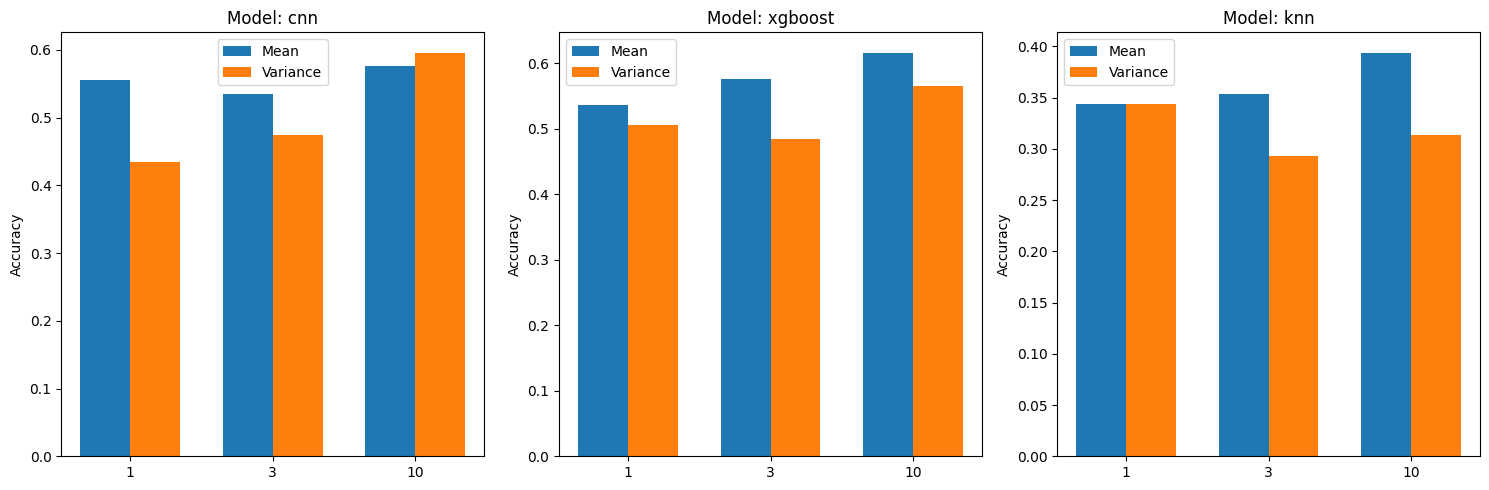

In [ ]:
def plot_test_accuracy_comparison_side_by_side(resultsmean, resultscontinuous):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    models = ['cnn', 'xgboost', 'knn']
    time_frames = sorted(resultsmean.keys())

    for i, model in enumerate(models):
        test_accuracies_mean = [resultsmean[time_frame][model]['test_accuracy'] for time_frame in time_frames]
        test_accuracies_continuous = [resultscontinuous[time_frame][model]['test_accuracy'] for time_frame in time_frames]

        x = range(len(time_frames))
        width = 0.35

        rects1 = axes[i].bar(x, test_accuracies_mean, width, label='Mean')
        rects2 = axes[i].bar([p + width for p in x], test_accuracies_continuous, width, label='Variance')

        axes[i].set_ylabel('Accuracy')
        axes[i].set_title(f'Model: {model}')
        axes[i].set_xticks([p + width / 2 for p in x])
        axes[i].set_xticklabels(time_frames)
        axes[i].legend()

    fig.tight_layout()
    plt.show()

plot_test_accuracy_comparison_side_by_side(results_continuous_mean, results_continuous_var)


The graphs indicate that using the mean of MFCCs generally results in higher accuracy across the models (CNN, XGBoost, and KNN) compared to using the variance. This suggests that the average spectral content of the audio is more indicative of the music genre than the variation in spectral content. Therefore, the mean of MFCCs what we chose to use moving forward.

### MFCC Split Segments

In [ ]:
def find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments=False):
    best_segments = {}
    segment_times = {}

    if not use_split_segments:
        for segment_length in segment_lengths:
            segments_info = segment_audio(audio, sr, segment_length)
            best_mean = float('-inf')
            best_segment = None
            best_time = None

            for segment, start_time, end_time in segments_info:
                features = extract_features(segment, sr)
                mean_mfccs = np.mean(features[0])
                if mean_mfccs > best_mean:
                    best_mean = mean_mfccs
                    best_segment = (segment, features)
                    best_time = (start_time, end_time)

            best_segments[segment_length] = best_segment
            segment_times[segment_length] = best_time
    else:
        for split_segment in split_segment_lengths:
            segments_info = segment_audio_split(audio, sr, split_segment, 10)
            best_mean = float('-inf')
            best_segment_info = None

            for segment, times in segments_info:
                features = extract_features(segment, sr)
                mean_mfccs = np.mean(features[0])

                if mean_mfccs > best_mean:
                    best_mean = mean_mfccs
                    best_segment_info = (segment, features, times)

            if best_segment_info:
                best_segments[tuple(split_segment)] = best_segment_info[:2]  # segment and features
                segment_times[tuple(split_segment)] = best_segment_info[2]  # times

    return best_segments, segment_times

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'
use_split_segments = True
max_files_per_genre = 99

resultssplit = music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre)

Using split segments

Segment Key: (0.5, 0.5)
CNN Results:
  Train Accuracy: 0.7437
  Validation Accuracy: 0.4545
  Test Accuracy: 0.4444
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5051
  Test Accuracy: 0.5556
KNN Results:
  Train Accuracy: 0.4255
  Validation Accuracy: 0.3434
  Test Accuracy: 0.3434
Best Model for Segment Key (0.5, 0.5): xgboost

Segment Key: (1, 2)
CNN Results:
  Train Accuracy: 0.7361
  Validation Accuracy: 0.4949
  Test Accuracy: 0.5253
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5960
  Test Accuracy: 0.5354
KNN Results:
  Train Accuracy: 0.4432
  Validation Accuracy: 0.3939
  Test Accuracy: 0.3535
Best Model for Segment Key (1, 2): xgboost

Segment Key: (1.5, 1.5)
CNN Results:
  Train Accuracy: 0.7273
  Validation Accuracy: 0.5758
  Test Accuracy: 0.5051
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5152
  Test Accuracy: 0.5859
KNN Results:
  Train Accuracy: 0.4280
  Validation Accuracy: 0.3434
  

Visualizing the Results

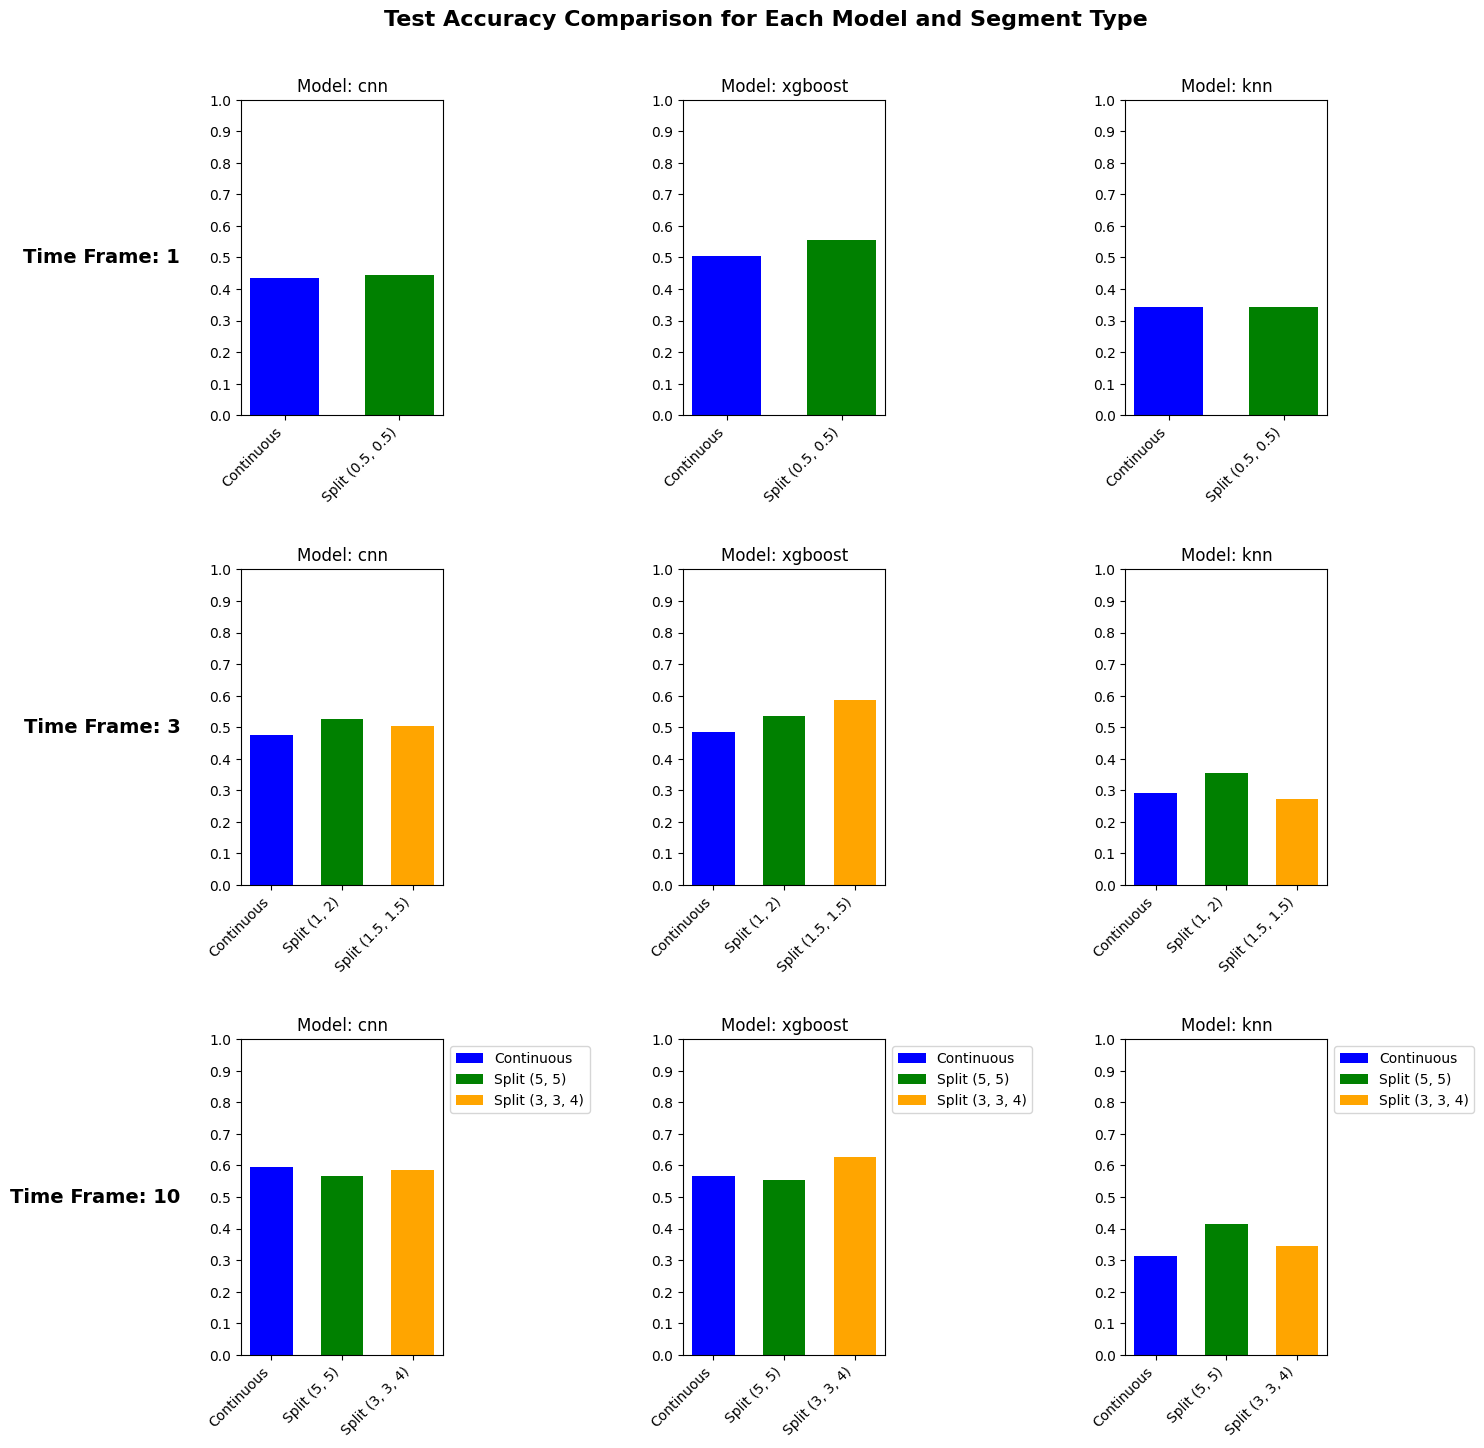

In [ ]:
segment_lengths = [1, 3, 10]
models = ['cnn', 'xgboost', 'knn']
split_colors = ['green', 'orange']


fig, axs = plt.subplots(len(segment_lengths), len(models), figsize=(15, 15))
for i, seg_len in enumerate(segment_lengths):
    continuous_key = seg_len
    split_keys = [key for key in resultssplit.keys() if sum(key) == seg_len]

    for m_index, model in enumerate(models):

        x_labels = ['Continuous'] + [f'Split {split_key}' for split_key in split_keys]
        x_pos = range(len(x_labels))

        # Continuous segments
        if continuous_key in results_continuous_var:
            axs[i, m_index].bar(x_pos[0], results_continuous_var[continuous_key][model]['test_accuracy'], width=0.6, label='Continuous', color='blue')

        # Split segments
        for j, split_key in enumerate(split_keys):
            if split_key in resultssplit:
                color = split_colors[j % len(split_colors)]
                axs[i, m_index].bar(x_pos[j+1], resultssplit[split_key][model]['test_accuracy'], width=0.6, label=f'Split {split_key}', color=color)

        axs[i, m_index].set_xticks(x_pos)
        axs[i, m_index].set_xticklabels(x_labels, rotation=45, ha='right')
        axs[i, m_index].set_ylim(0, 1)


        y_ticks = np.arange(0, 1.1, 0.1)
        axs[i, m_index].set_yticks(y_ticks)
        axs[i, m_index].set_yticklabels(['{:.1f}'.format(y) for y in y_ticks])

        axs[i, m_index].set_title(f'Model: {model}')
        if i == len(segment_lengths) - 1:
            axs[i, m_index].legend(loc='upper left', bbox_to_anchor=(1, 1))


    axs[i, 0].annotate(f'Time Frame: {seg_len}', xy=(-0.3, 0.5), xycoords='axes fraction', rotation=0, va='center', ha='right', fontsize=14, fontweight='bold')

plt.suptitle('Test Accuracy Comparison for Each Model and Segment Type', fontsize=16, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92, left=0.15)
plt.show()






Since the split timeframes generally perform better, as well as being  contained within the continuous time frames (5,5 can be 10 continuous) we chose to use split segments instead of continuous moving forward

### Spectral Features

Visualizing Spectral Features



Spectral Centroid: The plot of Spectral Centroid over time shows the center of mass of the frequency spectrum. It provides information about the brightness or sharpness of the sound, with higher values indicating a "brighter" or "sharper" sound.The peaks and valleys indicate moments when the sound becomes brighter or duller. For example, a sudden peak might indicate the entrance of a bright-sounding instrument like a cymbal crash or a high-pitched keyboard note.


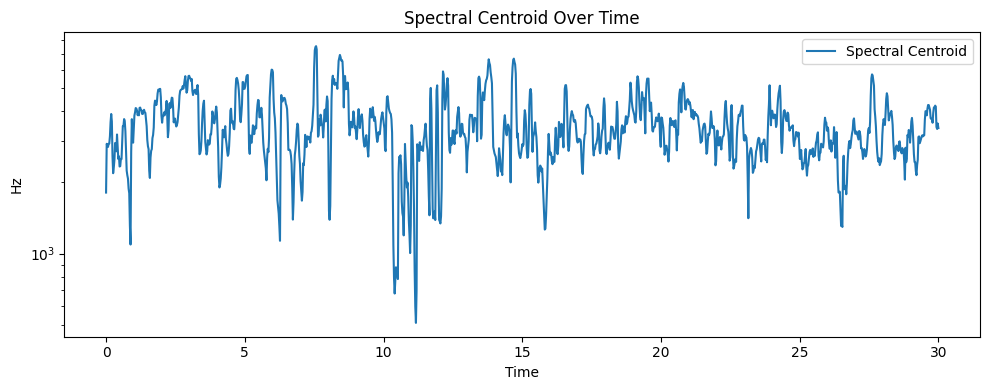

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/final_project/genres_new/pop/pop.00000.wav')

spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)

plt.figure(figsize=(10, 4))
plt.semilogy(librosa.frames_to_time(range(len(spectral_centroids[0]))), spectral_centroids[0], label='Spectral Centroid')
plt.xlabel('Time')
plt.ylabel('Hz')
plt.title('Spectral Centroid Over Time')
plt.legend()
plt.tight_layout()
plt.show()



Spectral Rolloff: The spectral rolloff point is the frequency below which a certain percentage of the total spectral energy, typically between 85% to 95%, is contained. It's a way to measure the "skewness" of the sound spectrum, which can give us an indication of where the "edge" of the majority of the sound energy lies. The deep and sharp drops in the graph indicate moments when the high-frequency energy decreases significantly. This could be when a high-pitched instrument stops playing or a change in the musical piece that introduces more low-frequency sounds.




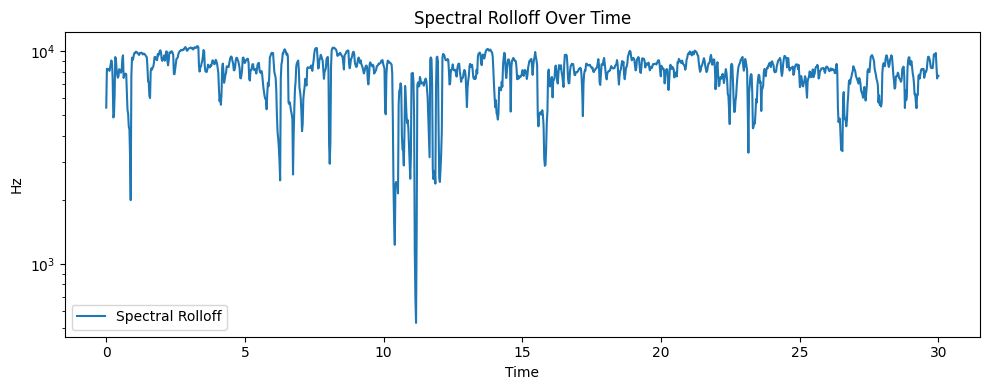

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(10, 4))
plt.semilogy(librosa.frames_to_time(range(len(spectral_rolloff))), spectral_rolloff, label='Spectral Rolloff')
plt.xlabel('Time')
plt.ylabel('Hz')
plt.title('Spectral Rolloff Over Time')
plt.legend()
plt.tight_layout()
plt.show()


Spectral Contrast: Essentially captures the peaks and troughs of the spectrum, which correspond to the harmonic (peak) and noise (valley) components of sound. In audio processing, spectral contrast can be used to identify musical phrases and note onsets, as these events often correspond to changes in contrast. It's particularly useful for genres with clear rhythmic components and distinct transitions between notes and chords.


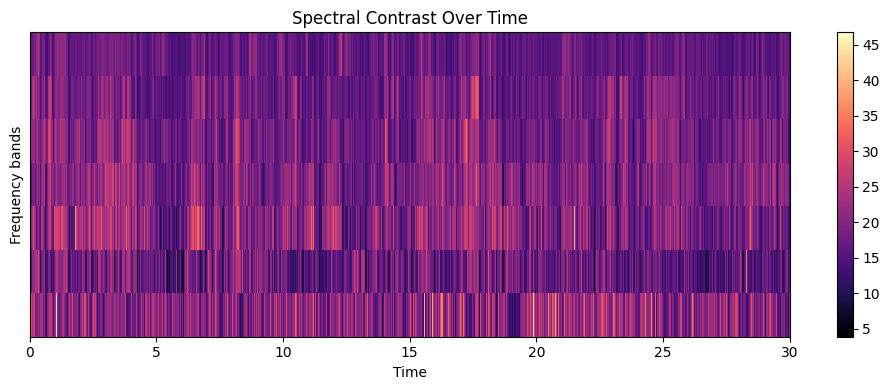

In [ ]:
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral Contrast Over Time')
plt.tight_layout()
plt.show()


In [ ]:
import librosa
import IPython.display as ipd

def play_audio_segment_from_file(file_path, start_sec, end_sec):
    """
    Plays an audio segment from the given audio file.

    Args:
        file_path (str): The path to the audio file.
        start_sec (float): The start time of the segment in seconds.
        end_sec (float): The end time of the segment in seconds.
    """
    y, sr = librosa.load(file_path)
    start_sample = int(start_sec * sr)
    end_sample = int(end_sec * sr)
    segment = y[start_sample:end_sample]
    ipd.display(ipd.Audio(segment, rate=sr))

# Example usage
file_path = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new/pop/pop.00000.wav'
play_audio_segment_from_file(file_path, 0, 15)

In [ ]:
def extract_spectral_features(y, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Compute the mean and variance of each feature
    features = np.concatenate([
        np.mean(spectral_centroid, axis=1),
        np.std(spectral_centroid, axis=1),
        np.mean(spectral_rolloff, axis=1),
        np.std(spectral_rolloff, axis=1),
        np.mean(spectral_contrast, axis=1),
        np.std(spectral_contrast, axis=1)
    ])
    return features


We need to modify the `find_best_segments` and `process_data` functions because we changed the feature extraction method. Instead of using MFCC features, we now extract spectral features (spectral centroid, spectral rolloff, and spectral contrast) using the `extract_spectral_features` function.



In [ ]:
def find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments=False):
    global segment_times

    best_segments = {}
    if not use_split_segments:
        for segment_length in segment_lengths:
            segments_info = segment_audio(audio, sr, segment_length)
            best_mean = float('-inf')
            best_segment = None
            best_time = None

            for segment, start_time, end_time in segments_info:
                features = extract_spectral_features(segment, sr)
                mean = np.mean(features)

                if mean > best_mean:
                    best_mean = mean
                    best_segment = (segment, features)
                    best_time = (start_time, end_time)

            best_segments[segment_length] = best_segment
            segment_times[segment_length] = best_time
    else:
        for split_segment in split_segment_lengths:
            segments_info = segment_audio_split(audio, sr, split_segment, 10)
            best_mean = float('-inf')
            best_segment_info = None

            for segment, times in segments_info:
                features = extract_spectral_features(segment, sr)
                mean = np.mean(features)

                if mean > best_mean:
                    best_mean = mean
                    best_segment_info = (segment, features, times)

            if best_segment_info:
                best_segments[tuple(split_segment)] = best_segment_info[:2]  # segment and features
                segment_times[tuple(split_segment)] = best_segment_info[2]  # times

    return best_segments, segment_times



In [ ]:
def process_data(data, segment_lengths, split_segment_lengths, use_split_segments=False):
    global segment_times  # global segment times dict

    X = {length: [] for length in (segment_lengths if not use_split_segments else [tuple(split) for split in split_segment_lengths])}
    y = []

    for file_path, genre in data:
        audio, sr = librosa.load(file_path)
        best_segments, times = find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments)
        segment_times.update(times)  # Update the global segment_times dictionary with the new times

        for segment_key, (segment, features) in best_segments.items():
            X[segment_key].append(features)
        y.append(genre)

    return X, y


In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'
use_split_segments = True
max_files_per_genre = 99

results_spectral = music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre)

Using split segments

Segment Key: (0.5, 0.5)
CNN Results:
  Train Accuracy: 0.6553
  Validation Accuracy: 0.5354
  Test Accuracy: 0.4848
XGBoost Results:
  Train Accuracy: 0.9899
  Validation Accuracy: 0.4444
  Test Accuracy: 0.4747
KNN Results:
  Train Accuracy: 0.4217
  Validation Accuracy: 0.4444
  Test Accuracy: 0.3838
Best Model for Segment Key (0.5, 0.5): cnn

Segment Key: (1, 2)
CNN Results:
  Train Accuracy: 0.6932
  Validation Accuracy: 0.5859
  Test Accuracy: 0.4343
XGBoost Results:
  Train Accuracy: 0.9924
  Validation Accuracy: 0.4747
  Test Accuracy: 0.5051
KNN Results:
  Train Accuracy: 0.4684
  Validation Accuracy: 0.4040
  Test Accuracy: 0.3131
Best Model for Segment Key (1, 2): xgboost

Segment Key: (1.5, 1.5)
CNN Results:
  Train Accuracy: 0.7096
  Validation Accuracy: 0.6263
  Test Accuracy: 0.5859
XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.5354
  Test Accuracy: 0.5859
KNN Results:
  Train Accuracy: 0.4280
  Validation Accuracy: 0.4545
  Test

### Spectral Features + MFCC Features

We created a new feature extraction function called `extract_combined_features` that combines both types of features. This function extracts the mean and variance of the MFCC coefficients, as well as the mean values of spectral rolloff, spectral centroid, and spectral contrast.

By combining these features, we aim to capture a more comprehensive representation of the audio signal, leveraging both the spectral and timbral (unique) characteristics. The MFCC features provide information about the overall spectral envelope and on the other hand, the spectral features capture specific aspects of the audio, such as the brightness (spectral centroid), the shape of the spectrum (spectral rolloff), and the relative energy distribution across frequency bands (spectral contrast).

By incorporating both types of features, we expect to improve the models' ability to discriminate between different music genres. The combined feature set provides a richer representation of the audio signal, allowing the models to learn from a broader range of characteristics and potentially enhance their classification performance.



In [ ]:
def extract_combined_features(audio_segment, sr, n_mfcc=13):
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=n_mfcc)
    mean_mfccs = np.mean(mfccs, axis=1)
    var_mfccs = np.var(mfccs, axis=1)

    # Extract spectral features
    rolloff = librosa.feature.spectral_rolloff(y=audio_segment, sr=sr)[0]
    centroid = librosa.feature.spectral_centroid(y=audio_segment, sr=sr)[0]
    contrast = librosa.feature.spectral_contrast(y=audio_segment, sr=sr)
    mean_rolloff = np.mean(rolloff)
    mean_centroid = np.mean(centroid)
    mean_contrast = np.mean(contrast, axis=1)

    # Combine MFCC and spectral features
    combined_features = np.concatenate((mean_mfccs, var_mfccs, [mean_rolloff, mean_centroid], mean_contrast))

    return combined_features

In [ ]:
def prepare_data(X, y, scaler_type='standard'):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    X_scaled = {}
    for segment_key, features in X.items():
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()
        X_scaled[segment_key] = scaler.fit_transform(features)
    return X_scaled, y_encoded, label_encoder


In [ ]:
def find_best_segments_combined(audio, sr, segment_lengths, split_segment_lengths, use_split_segments=False):
    best_segments = {}
    segment_times = {}
    genre_scores = {}  #dictionary to store scores per music genre


    if not use_split_segments:
        for segment_length in segment_lengths:
            segments_info = segment_audio(audio, sr, segment_length)
            best_score = float('-inf')
            best_segment = None
            best_time = None

            for segment, start_time, end_time in segments_info:
                combined_features = extract_combined_features(segment, sr)
                score = np.mean(combined_features)
                if score > best_score:
                    best_score = score
                    best_segment = (segment, combined_features)
                    best_time = (start_time, end_time)

            best_segments[segment_length] = best_segment
            segment_times[segment_length] = best_time
    else:
        for split_segments in split_segment_lengths:
            segments_info = segment_audio_split(audio, sr, split_segments)
            best_score = float('-inf')
            best_segment = None
            best_time = None

            for segment, times in segments_info:
                combined_features = extract_combined_features(segment, sr)
                score = np.mean(combined_features)
                if score > best_score:
                    best_score = score
                    best_segment = (segment, combined_features)
                    best_time = times

            best_segments[tuple(split_segments)] = best_segment
            segment_times[tuple(split_segments)] = best_time

    return best_segments, segment_times






In [ ]:
def process_data(data, segment_lengths, split_segment_lengths, use_split_segments=False, use_combined_features=True):
    global segment_times  #global dictionary for segment times

    X = {length: [] for length in (segment_lengths if not use_split_segments else [tuple(split) for split in split_segment_lengths])}
    y = []

    for file_path, genre in data:
        audio, sr = librosa.load(file_path)

        if use_combined_features:
            best_segments, times = find_best_segments_combined(audio, sr, segment_lengths, split_segment_lengths, use_split_segments)
        else:
            best_segments, times = find_best_segments(audio, sr, segment_lengths, split_segment_lengths, use_split_segments)

        segment_times.update(times)  # Update the global segment_times dictionary

        for segment_key, (segment, features) in best_segments.items():
            if use_combined_features:
                X[segment_key].append(features)
            else:
                X[segment_key].append(np.concatenate(features))

        y.append(genre)

    return X, y


In [ ]:
genre_scores = {}

def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test_encoded, segment_keys, label_encoder):
    global segment_times, genre_scores

    results = {}

    for segment_key in segment_keys:
        cnn_model, cnn_history = models[segment_key]['cnn']
        xgboost_model = models[segment_key]['xgboost']
        knn_model = models[segment_key]['knn']

        cnn_test_acc = cnn_model.evaluate(X_test[segment_key].reshape(-1, X_test[segment_key].shape[1], 1), y_test_encoded, verbose=0)[1]
        xgboost_test_acc = accuracy_score(y_test_encoded, xgboost_model.predict(X_test[segment_key]))
        knn_test_acc = accuracy_score(y_test_encoded, knn_model.predict(X_test[segment_key]))

        model_accuracies = {'cnn': cnn_test_acc, 'xgboost': xgboost_test_acc, 'knn': knn_test_acc}
        best_model = max(model_accuracies, key=model_accuracies.get)

        segment_key_str = str(segment_key) if isinstance(segment_key, tuple) else segment_key

        results[segment_key_str] = {
            'best_model': best_model,
            'accuracy': model_accuracies[best_model],
            'start_end_times': segment_times.get(segment_key, [])
        }

        # Update the genre_scores dictionary with the accuracy scores for each genre
        best_model_name = results[segment_key_str]['best_model']
        if best_model_name == 'cnn':
            y_test_pred = cnn_model.predict(X_test[segment_key].reshape(-1, X_test[segment_key].shape[1], 1)).argmax(axis=1)
        elif best_model_name == 'xgboost':
            y_test_pred = xgboost_model.predict(X_test[segment_key])
        else:  # knn
            y_test_pred = knn_model.predict(X_test[segment_key])

        for genre_label in set(y_test_encoded):
            genre_mask = y_test_encoded == genre_label
            if np.sum(genre_mask) > 0:
                genre_acc = accuracy_score(y_test_encoded[genre_mask], y_test_pred[genre_mask])
                genre = label_encoder.inverse_transform([genre_label])[0]  # Convert label back to genre name for graph
                genre_scores.setdefault(segment_key_str, {})[genre] = genre_acc
            else:
                genre = label_encoder.inverse_transform([genre_label])[0]  # Convert label back to genre name for graph
                genre_scores.setdefault(segment_key_str, {})[genre] = None

    with open('best_model_results.json', 'w') as f:
        json.dump(results, f, indent=4)

    return results



In [ ]:
def analyze_model_confusions(models, X_test, y_test, segment_keys, label_encoder):
    num_genres = len(label_encoder.classes_)

    for segment_key in segment_keys:
        confusion_matrix_segment = np.zeros((num_genres, num_genres), dtype=int)

        model_data = models[segment_key]
        for model_name, model_info in model_data.items():
            model = model_info[0] if isinstance(model_info, tuple) else model_info

            X_test_segment = X_test[segment_key]
            if 'cnn' in model_name and X_test_segment.ndim != 3:
                X_test_segment = X_test_segment.reshape(X_test_segment.shape[0], X_test_segment.shape[1], 1)
            elif 'xgboost' in model_name and X_test_segment.ndim == 3:
                X_test_segment = X_test_segment.reshape(X_test_segment.shape[0], -1)

            y_pred = model.predict(X_test_segment)
            if y_pred.ndim > 1 and y_pred.shape[1] > 1:
                y_pred = y_pred.argmax(axis=1)

            for true_label, pred_label in zip(y_test, y_pred):
                if true_label != pred_label:
                    confusion_matrix_segment[true_label, pred_label] += 1


        plt.figure(figsize=(12, 10))
        sns.heatmap(confusion_matrix_segment, annot=True, fmt='d', cmap='YlGnBu',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted Genre')
        plt.ylabel('True Genre')
        plt.title(f'Genre Confusion Matrix - Segment Key: {segment_key}')
        plt.tight_layout()
        plt.show()



In [ ]:
def music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre):
    segment_lengths = [1, 3, 10]
    split_segment_lengths = [(0.5, 0.5), (1, 2), (1.5, 1.5), (5, 5), (3, 3, 4)]

    data = load_data(base_dir, max_files_per_genre=max_files_per_genre)
    train_data, val_data, test_data = split_data(data)

    X_train, y_train = process_data(train_data, segment_lengths, split_segment_lengths, use_split_segments)
    X_val, y_val = process_data(val_data, segment_lengths, split_segment_lengths, use_split_segments)
    X_test, y_test = process_data(test_data, segment_lengths, split_segment_lengths, use_split_segments)

    X_train_scaled_cnn, y_train_encoded, label_encoder = prepare_data(X_train, y_train)
    X_val_scaled_cnn, y_val_encoded, _ = prepare_data(X_val, y_val)
    X_test_scaled_cnn, y_test_encoded, _ = prepare_data(X_test, y_test)

    X_train_scaled_knn, _,_ = prepare_data(X_train, y_train, scaler_type='minmax')
    X_val_scaled_knn, _,_ = prepare_data(X_val, y_val, scaler_type='minmax')
    X_test_scaled_knn, _,_ = prepare_data(X_test, y_test, scaler_type='minmax')

    num_classes = len(set(y_train))
    segment_keys = list(X_train_scaled_cnn.keys())

    models = {}
    for segment_key in segment_keys:
        cnn_model, cnn_history = train_cnn(X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, segment_key, num_classes)
        xgboost_model = train_xgboost(X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, segment_key)
        knn_model = train_knn(X_train_scaled_knn[segment_key], y_train_encoded, X_val_scaled_knn[segment_key], y_val_encoded)

        models[segment_key] = {
            'cnn': (cnn_model, cnn_history),
            'xgboost': xgboost_model,
            'knn': knn_model
        }

    results = evaluate_models(models, X_train_scaled_cnn, y_train_encoded, X_val_scaled_cnn, y_val_encoded, X_test_scaled_cnn, y_test_encoded, segment_keys, label_encoder)
    analyze_model_confusions(models, X_test_scaled_cnn, y_test_encoded, segment_keys, label_encoder)


    print(f"Using {'split segments' if use_split_segments else 'continuous segments'}")

    for segment_key in results.keys():
        result = results[segment_key]
        best_model = result['best_model']
        accuracy = result['accuracy']
        start_end_times = result['start_end_times']

        print(f"\nSegment Key: {segment_key}")
        print(f"Best Model: {best_model}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Start-End Times: {start_end_times}")


    return results






4/4 [==============================] - 0s 5ms/step


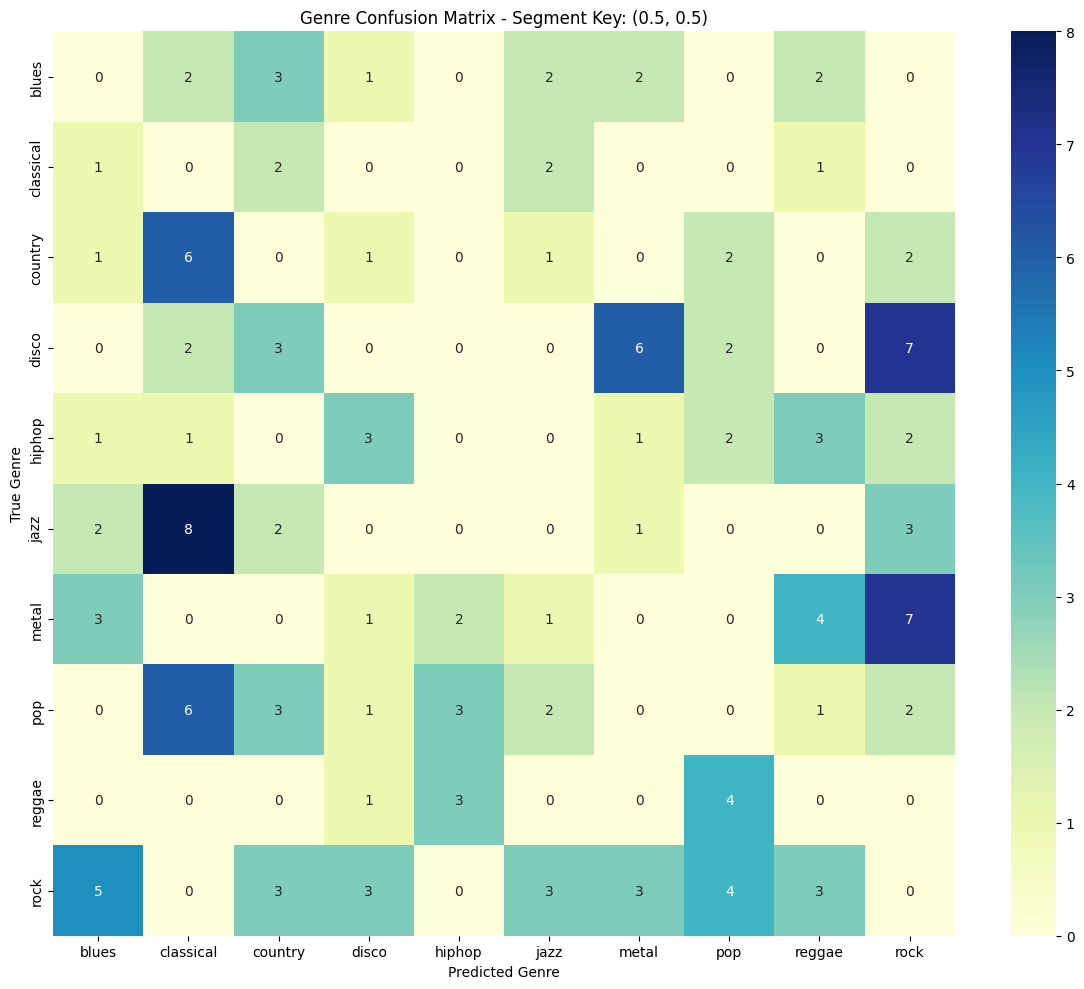

4/4 [==============================] - 0s 5ms/step


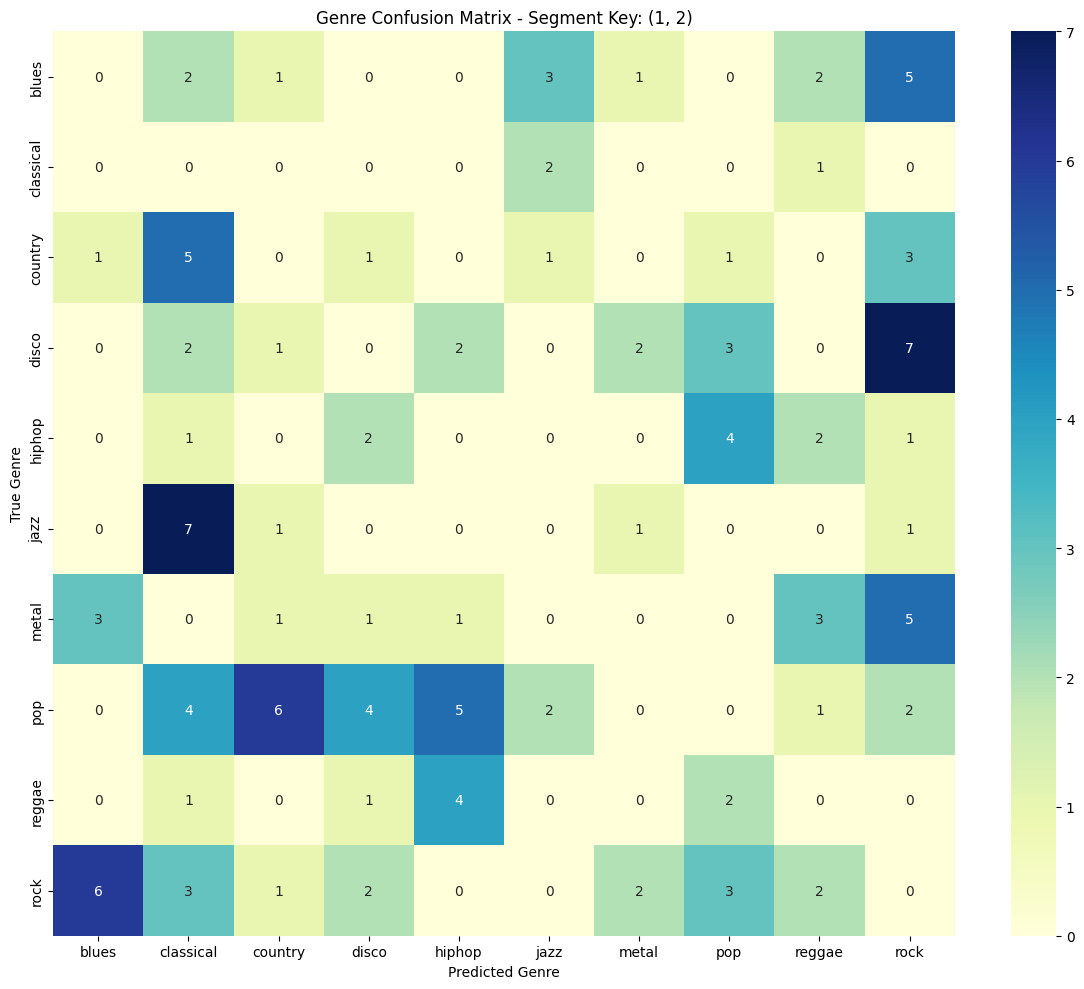

4/4 [==============================] - 0s 5ms/step


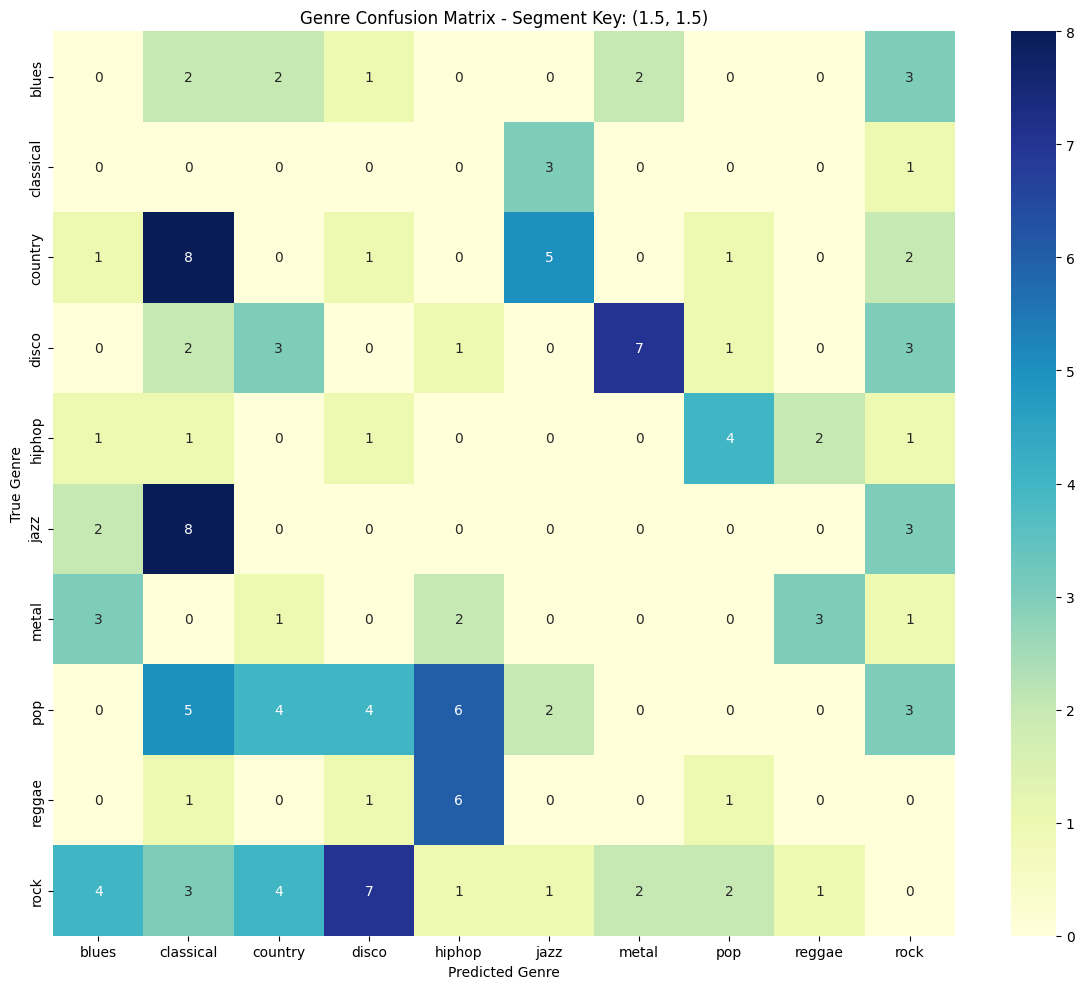

4/4 [==============================] - 0s 5ms/step


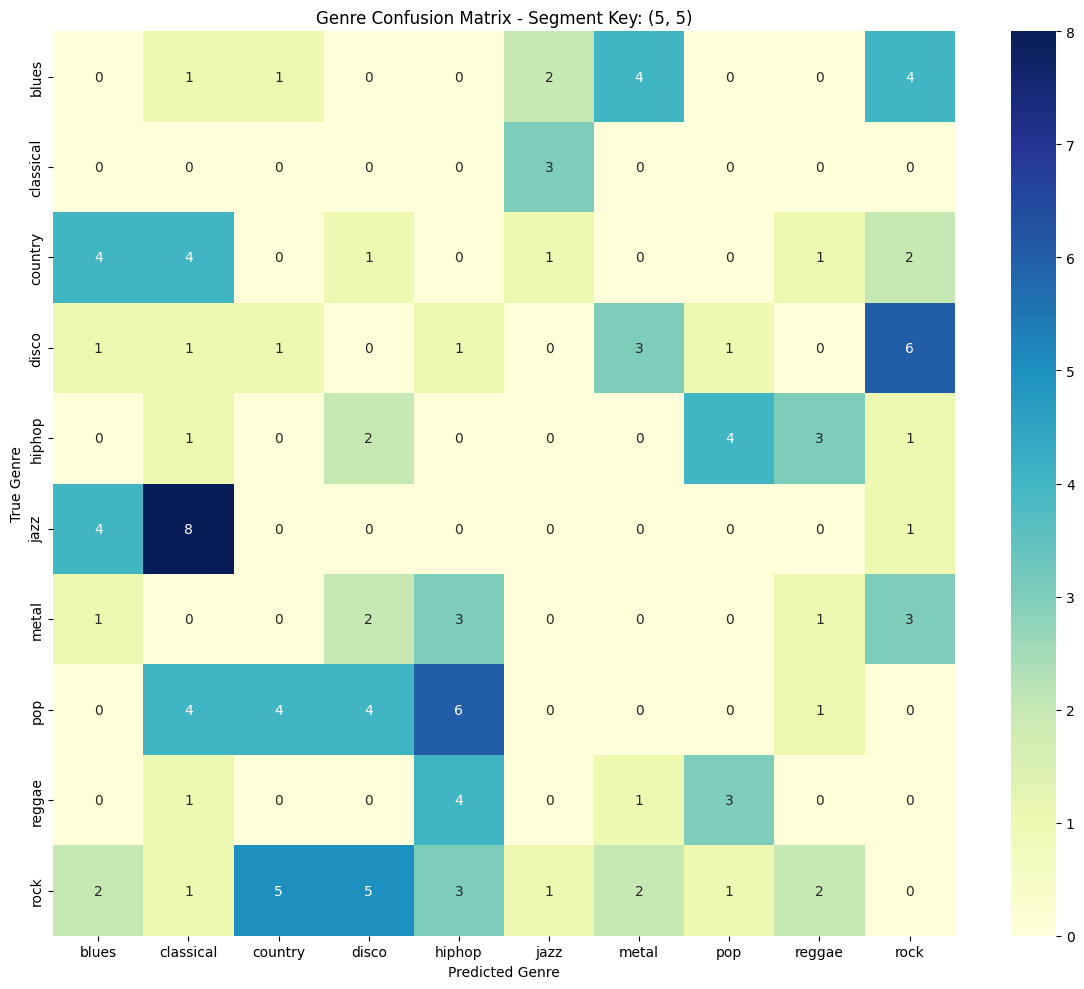

4/4 [==============================] - 0s 6ms/step


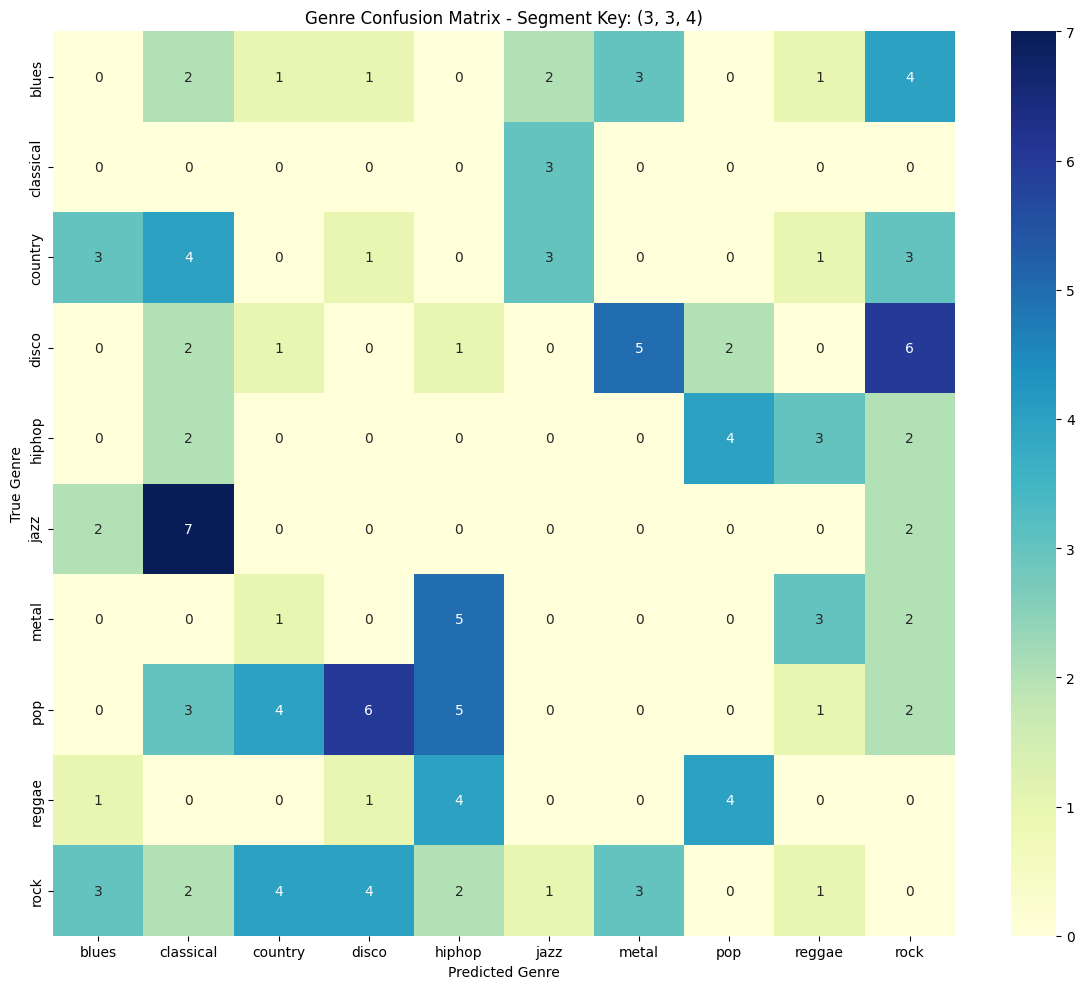

Using split segments

Segment Key: (0.5, 0.5)
Best Model: xgboost
Test Accuracy: 0.6364
Start-End Times: [(9.6, 10.1), (21.1, 21.6)]

Segment Key: (1, 2)
Best Model: cnn
Test Accuracy: 0.6667
Start-End Times: [(5.0, 6.0), (26.8, 28.8)]

Segment Key: (1.5, 1.5)
Best Model: xgboost
Test Accuracy: 0.6162
Start-End Times: [(23.8, 25.3), (27.5, 29.0)]

Segment Key: (5, 5)
Best Model: xgboost
Test Accuracy: 0.7071
Start-End Times: [(24.2, 29.2), (15.9, 20.9)]

Segment Key: (3, 3, 4)
Best Model: xgboost
Test Accuracy: 0.6768
Start-End Times: [(22.6, 25.6), (24.2, 27.2), (21.0, 25.0)]


In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'
use_split_segments = True
max_files_per_genre = 99

results_combined= music_genre_classification_pipeline(base_dir, use_split_segments, max_files_per_genre)

Analyzing the above confusion Matrices:


'jazz' shows confusion with 'classical' which might be due to certain jazz subgenres that incorporate elements from this genre

'rock' has been confused with 'blues' and 'metal', which can happen due to the shared origins of blues and rock and the potential overlap in aggressive sound or tempo with metal.

High misclassification between 'hiphop' and 'pop', which could be due to overlapping rhythmic patterns or use of similar instrumentation in these genres, particularly in popular music where there is a blend of these two genres.

There's a notable misclassification between 'pop' and 'disco' (especially for shorter segments), likely due to the common use of a strong, danceable beat, and sometimes a similar tempo.

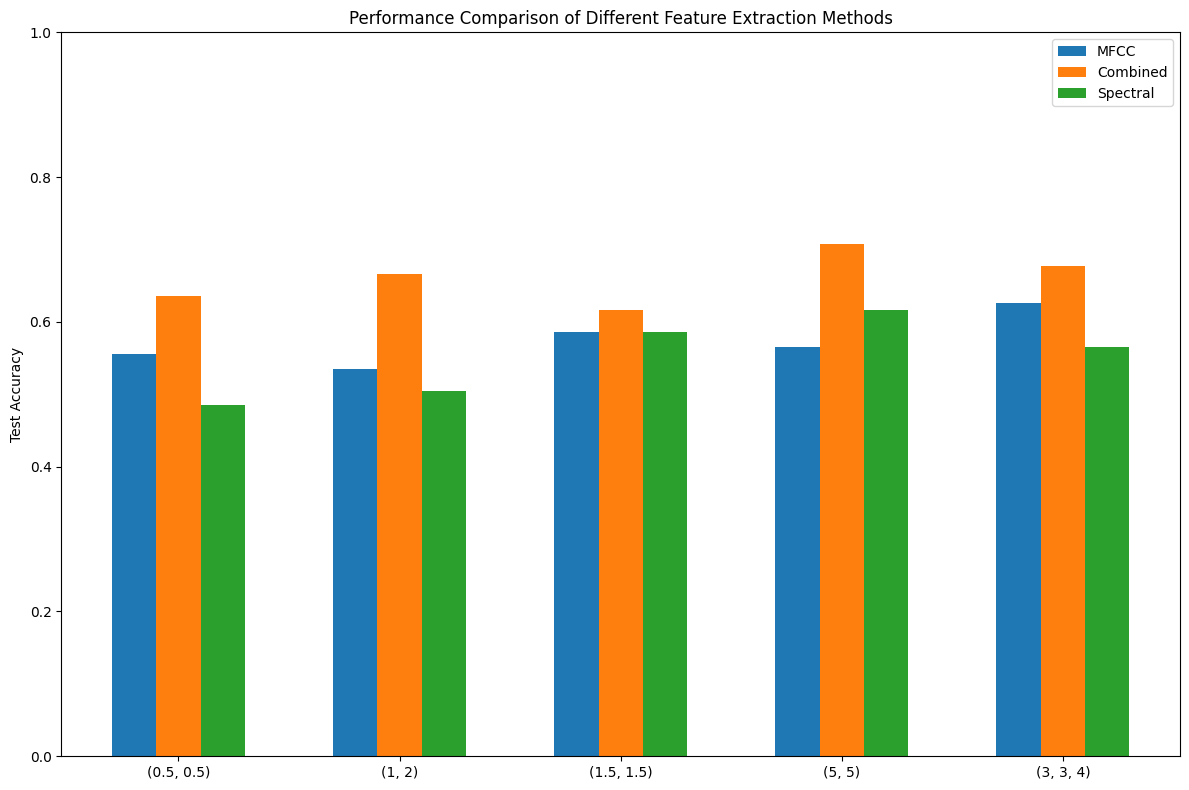

In [ ]:
def plot_performance_comparison(results_list, labels):
    models = ['cnn', 'xgboost', 'knn']
    segment_lengths = [(0.5, 0.5), (1, 2), (1.5, 1.5), (5, 5), (3, 3, 4)]

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(len(segment_lengths))
    width = 0.2

    for i, results in enumerate(results_list):
        accuracies = []
        for segment_length in segment_lengths:
            best_accuracy = 0
            if isinstance(results, dict) and str(segment_length) in results:
                # Check if the result is from result_combined
                if 'accuracy' in results[str(segment_length)]:
                    best_accuracy = results[str(segment_length)]['accuracy']
            else:
                # Handle other result formats
                for model in models:
                    if segment_length in results and model in results[segment_length]:
                        accuracy = results[segment_length][model]['test_accuracy']
                        best_accuracy = max(best_accuracy, accuracy)
            accuracies.append(best_accuracy)

        ax.bar(x + i * width, accuracies, width, label=labels[i])

    ax.set_xticks(x + width * (len(results_list) - 1) / 2)
    ax.set_xticklabels([str(length) for length in segment_lengths])
    ax.set_ylabel('Test Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title('Performance Comparison of Different Feature Extraction Methods')
    ax.legend()

    plt.tight_layout()
    plt.show()


results_list = [resultssplit, results_combined, results_spectral]
labels = ['MFCC', 'Combined', 'Spectral']

plot_performance_comparison(results_list, labels)




As can be seen, our highest accuracy so far is using the spectral and MFCC features. As mentioned before testing this feature set,the combined features likely provide the best performance because they offer a more comprehensive representation of the audio signal by integrating information captured by both MFCC and spectral features.

# Results & Visualization

The following results correspond to the results from the combined feature set.

First, well choose the split segments for each continuous time frame (1,3,10) with the best results

In [ ]:
def get_best_scores_and_times(json_data, total_time_windows):
    # Initialize a dictionary to store the best scores, times, and sub-windows for each total time window
    best_scores_and_times = {}


    for window in total_time_windows:
        best_score = 0
        best_times = []
        best_sub_windows = []

        # Iterate over the data entries
        for key, value in json_data.items():
            segment_lengths = eval(key)
            total_length = sum(segment_lengths)


            if total_length == window:
                accuracy = value['accuracy']


                if accuracy > best_score:
                    best_score = accuracy
                    best_times = value['start_end_times']
                    best_sub_windows = segment_lengths


        best_scores_and_times[window] = {
            'best_score': best_score,
            'best_times': best_times,
            'best_sub_windows': best_sub_windows
        }

    return best_scores_and_times



### Best Results

In [ ]:

with open('best_model_results.json') as file:
    data = json.load(file)


total_time_windows = [1, 3, 10]


results = get_best_scores_and_times(data, total_time_windows)


for window, result in results.items():
    print(f"Total Time Window: {window} seconds")
    print(f"Best Sub-Windows: {result['best_sub_windows']}")
    print(f"Best Score: {round(result['best_score'],4)}")
    print(f"Best Times: {result['best_times']}")
    print()

Total Time Window: 1 seconds
Best Sub-Windows: (0.5, 0.5)
Best Score: 0.6364
Best Times: [[9.6, 10.1], [21.1, 21.6]]

Total Time Window: 3 seconds
Best Sub-Windows: (1, 2)
Best Score: 0.6667
Best Times: [[5.0, 6.0], [26.8, 28.8]]

Total Time Window: 10 seconds
Best Sub-Windows: (5, 5)
Best Score: 0.7071
Best Times: [[24.2, 29.2], [15.9, 20.9]]



These are our final results. The results suggest that for audio genre classification, longer analysis windows with corresponding sub-windows yield higher accuracy, indicating that capturing more extended temporal features is beneficial for identifying the genre.

Lets visualize and hear the results

### Accuracy Per Genre

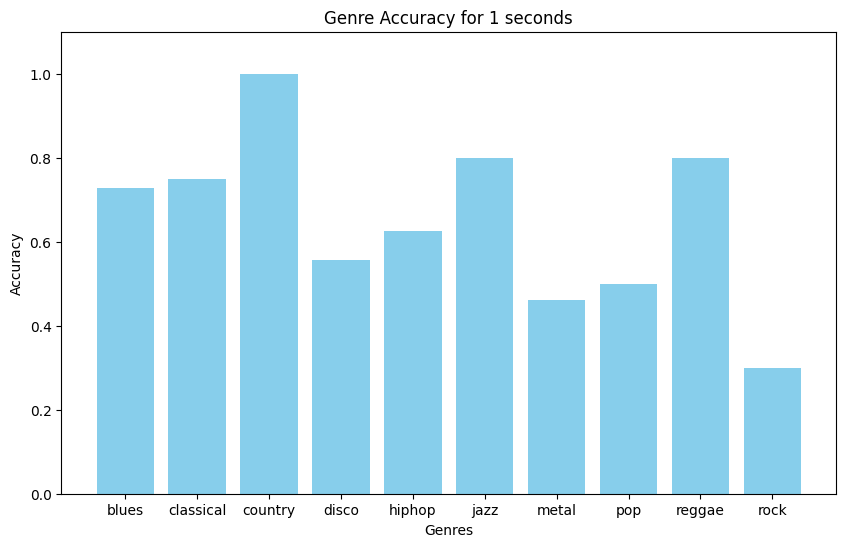

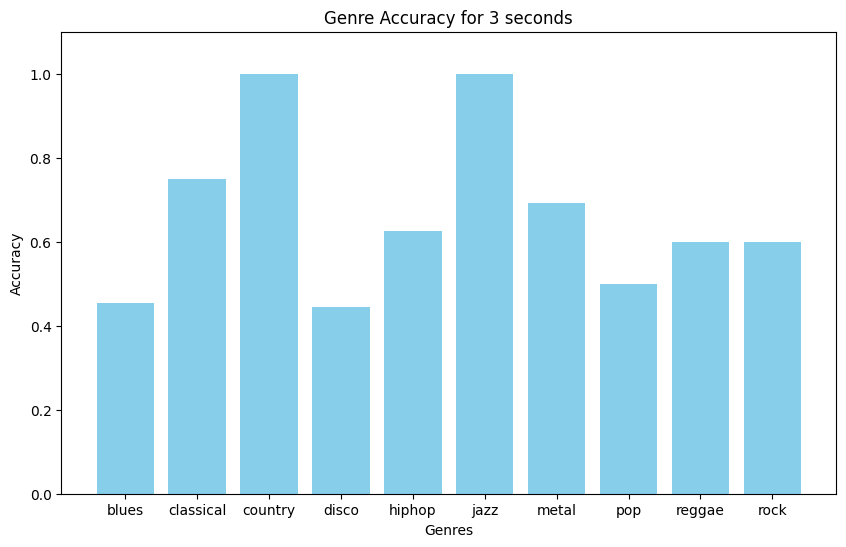

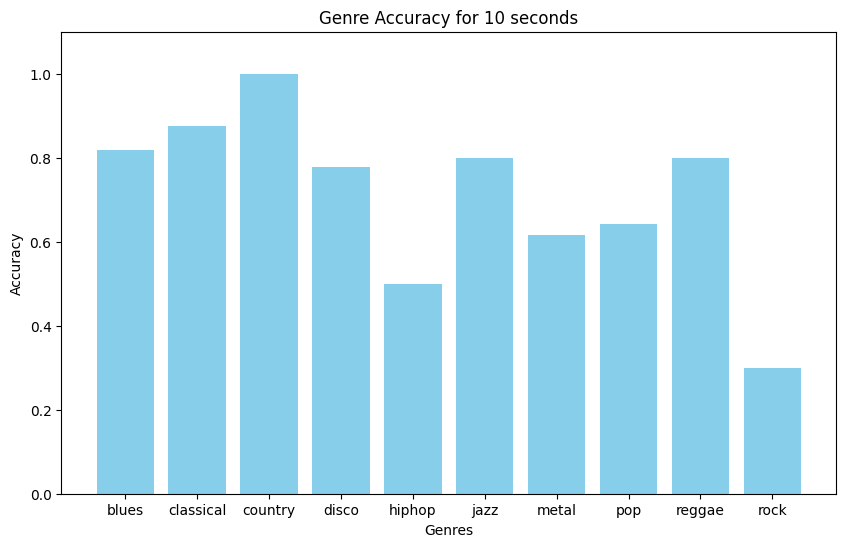

In [ ]:
for full_time, data in results.items():
    best_sub_window = str(data['best_sub_windows'])
    scores = genre_scores[best_sub_window] if best_sub_window in genre_scores else {}

    plt.figure(figsize=(10, 6))
    genres = list(scores.keys())
    accuracies = list(scores.values())
    plt.bar(genres, accuracies, color='skyblue')
    plt.xlabel('Genres')
    plt.ylabel('Accuracy')
    plt.title(f'Genre Accuracy for {full_time} seconds')
    plt.ylim(0, 1.1)
    plt.show()


In the first graph (1-second window), accuracy varies significantly across genres, suggesting that short snippets may not contain enough information to accurately distinguish between all genres. Some (like country) show high accuracy, likely due to distinctive characteristics that manifest quickly.

The second graph (3-second window) shows a general improvement in accuracy for most genres compared to the 1-second window, indicating that a slightly longer context provides more reliable indicators for genre classification, though some genres like disco & blues still present challenges.

The third graph (10-second window) shows further improved accuracy across most genres, which reinforces the idea that longer audio samples capture more defining musical elements necessary for accurate genre classification.

Another interesting observation is results that actually decrease as the time increases (for example rock from 3 to 10 seconds).
This makes sense as short splits of a certain song can be very specific to it, increasing its connection to the genre, but while time goes on the song can begin to sound like a different genre, causing confusion.








### Lets Hear the Music

In [ ]:
import IPython.display as ipd

def play_all_segments(results_dict, base_dir, file_paths):

    for file_path in file_paths:
        full_path = os.path.join(base_dir, file_path)
        audio, sr = librosa.load(full_path)

        print(f"Playing all segments from {file_path}:")
        for full_time, segment_info in results_dict.items():
            times = segment_info['best_times']
            print(f"\nSplit {segment_info['best_sub_windows']}:")

            for time_pair in times:
                start_time, end_time = time_pair
                start_sample = int(start_time * sr)
                end_sample = int(end_time * sr)
                segment = audio[start_sample:end_sample]

                print(f"Segment {start_time} to {end_time} seconds:")
                ipd.display(ipd.Audio(segment, rate=sr))


base_dir = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new'
file_paths = ['pop/pop.00002.wav', 'jazz/jazz.00000.wav']
play_all_segments(results, base_dir, file_paths)

Playing all segments from pop/pop.00002.wav:

Split (0.5, 0.5):
Segment 9.6 to 10.1 seconds:


Segment 21.1 to 21.6 seconds:



Split (1, 2):
Segment 5.0 to 6.0 seconds:


Segment 26.8 to 28.8 seconds:



Split (5, 5):
Segment 24.2 to 29.2 seconds:


Segment 15.9 to 20.9 seconds:


Playing all segments from jazz/jazz.00000.wav:

Split (0.5, 0.5):
Segment 9.6 to 10.1 seconds:


Segment 21.1 to 21.6 seconds:



Split (1, 2):
Segment 5.0 to 6.0 seconds:


Segment 26.8 to 28.8 seconds:



Split (5, 5):
Segment 24.2 to 29.2 seconds:


Segment 15.9 to 20.9 seconds:


NOTE TO READER: If you are not viewing this in Google Colab, please visit the following link and scroll to the end to be able to hear the music!
https://colab.research.google.com/drive/1jpIABtmnNitBRVHOyE3qJb7v04X69IHK#scrollTo=ypZBS_A4ESWA



This is how the split segments sound.

The chosen segments from the pop song are very much representative of the genre, but as seen before can be easily confused with Hiphop and Disco.

The jazz song chosen is interesting in regards to the above confusion matrix. It was observed that many songs predicts as Classical were in fact Jazz songs. After hearing this specific song, this makes sense as it sounds very much like a Classical genre song.

### Visualizing the Segments with MFCC

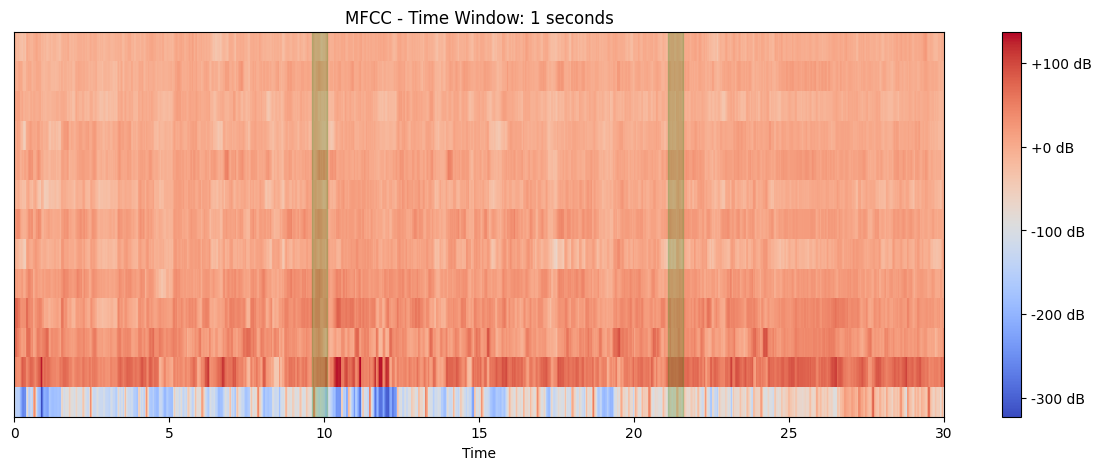

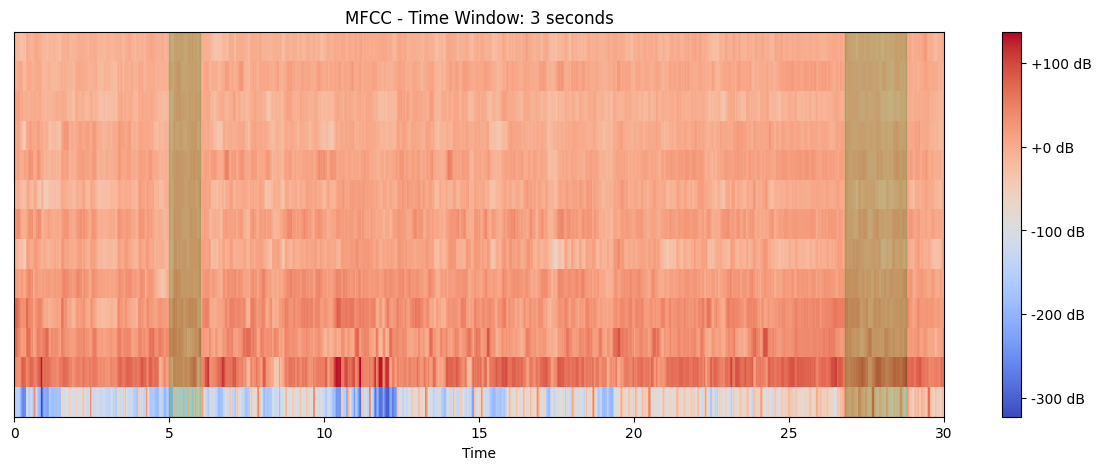

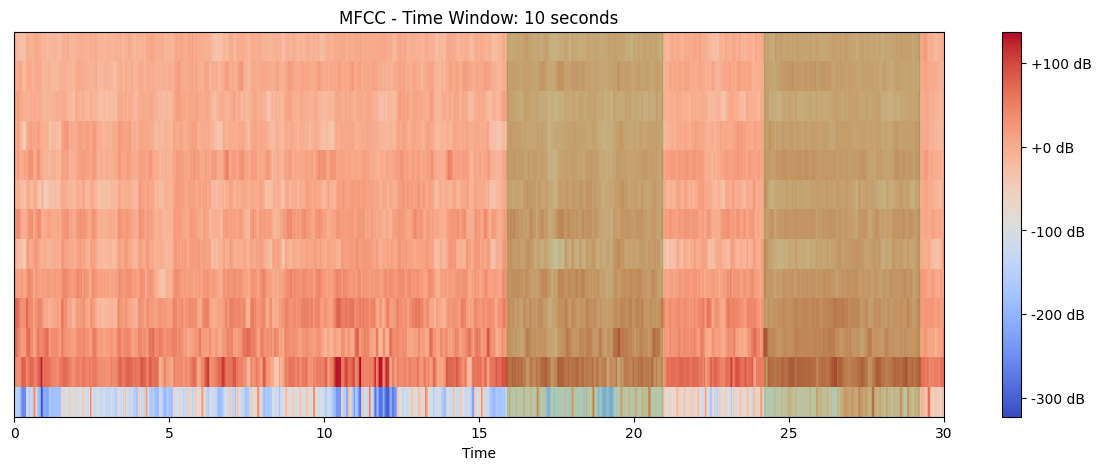

In [ ]:
def plot_mfcc_with_segments(file_path, sr, time_frames, time_window):
    audio, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    plt.figure(figsize=(15, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC - Time Window: {time_window} seconds')

    # Highlight the chosen time frames
    for start, end in time_frames:
        plt.axvspan(start, end, color='green', alpha=0.2)

    plt.show()

results = {
    1: {
        'Best Sub-Windows': (0.5, 0.5),
        'Best Score': 0.6364,
        'Best Times': [[9.6, 10.1], [21.1, 21.6]]
    },
    3: {
        'Best Sub-Windows': (1, 2),
        'Best Score': 0.6667,
        'Best Times': [[5.0, 6.0], [26.8, 28.8]]
    },
    10: {
        'Best Sub-Windows': (5, 5),
        'Best Score': 0.7071,
        'Best Times': [[24.2, 29.2], [15.9, 20.9]]
    }
}

file_path = '/content/drive/MyDrive/Colab Notebooks/final_project/genres_new/pop/pop.00000.wav'
sampling_rate = 22050

for time_window, result in results.items():
    time_frames = result['Best Times']
    plot_mfcc_with_segments(file_path, sampling_rate, time_frames, time_window)




These graphs illustrate the MFCCs extracted from the pop song, highlighting the most significant segments identified by the model for classifying the genre. The plots provide insights into the spectral content and important regions of the audio signal at different time resolutions, showing how the audio characteristics vary over time. The green vertical spans represent the most representative or informative portions of the audio for each time window, based on the combined features. Areas matching the red end of the decibel scale indicate the strongest frequency components, while those matching the blue end are the weakest. It can be observed that our model mostly chose the darker, stronger areas. For this specific song, there is a high decibel area between 10-13 seconds that our model missed. With different preprocessing and decision methods, higher accuracy could have been achieved if segments like this were chosen instead







